## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 6.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


In [4]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [5]:
import cv2
if not os.path.exists("./TrainImgs/train_images.txt"):
    # 產生訓練集清單 train_images.txt
    def file_inFolder(path, list_name):
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isdir(file_path):
                #listdir(file_path, list_name)
                a = 0
            elif os.path.isfile(file_path):
                list_name.append(file_path)

    folderPath1 = "./TrainImgs/kangaroo/images/"
    fileList = []
    file_inFolder(folderPath1, fileList)
    folderPath2 = "./TrainImgs/raccoon/images/"
    file_inFolder(folderPath2, fileList)
    fileList_path = "./TrainImgs/train_images.txt"
    with open(fileList_path, 'a') as list_file:
        for fileName in fileList:
            list_file.write(fileName)
            list_file.write('\n')
    print("Done writing train list")
else:
    print("train_images.txt exist")

train_images.txt exist


In [7]:
if not os.path.exists("TrainImgs/train_anno .txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    annots = {'kangaroo': './TrainImgs/kangaroo/annotation/', 'raccoon': './TrainImgs/raccoon/annotation/'}

    # 專題的辨識目標 
    categories = ['kangaroo', 'raccoon']

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(annot_path, image_file, list_file):
        image_id = os.path.splitext(os.path.basename(image_file))[0]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation_augHor(annot_path, image_file, list_file):
        tmpImg = cv2.imread(image_file)
        #print("image_file", image_file)
        rows = tmpImg.shape[0]
        cols = tmpImg.shape[1]
        
        image_id = os.path.splitext(os.path.basename(image_file))[0]
        image_id = image_id[4::]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = ((cols - int(xmlbox.find('xmin').text)), int(xmlbox.find('ymin').text), (cols - int(xmlbox.find('xmax').text)), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    annotation_path = './TrainImgs/train_anno.txt'
    with open(annotation_path, 'a') as list_file:
        print("save annotation at %s" % annotation_path)
        image_files = open('./TrainImgs/train_images.txt').read().strip().split()
        cnt = 0
        for image_file in image_files:
            folder, name = os.path.split(image_file)
            if (name[0]=='r') or (name[4]=='r'):
                annot_path = "./TrainImgs/raccoon/annotations/"
            else:
                annot_path = "./TrainImgs/kangaroo/annotations/"
            list_file.write(image_file)
            if (cnt % 2)==0:
                convert_annotation(annot_path, image_file, list_file)
            else:
                convert_annotation_augHor(annot_path, image_file, list_file)
                list_file.write('\n')
                cnt = cnt + 1
            list_file.close()
else:
    print('annotation data is existed!!')

annotation data is existed!!


In [8]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [10]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
annotation_path = 'TrainImgs/train_anno .txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/final_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 8
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 8.
Epoch 1/50
41/41 [==============================] - 231s 6s/step - loss: 1447.8510 - val_loss: 221.5768

Epoch 2/50
41/41 [==============================] - 30s 722ms/step - loss: 151.1754 - val_loss: 110.2370
Epoch 3/50
41/41 [==============================] - 31s 755ms/step - loss: 92.3367 - val_loss: 70.0034
Epoch 4/50
41/41 [==============================] - 26s 631ms/step - loss: 68.8565 - val_loss: 57.0693
Epoch 5/50
41/41 [==============================] - 32s 773ms/step - loss: 56.4869 - val_loss: 45.8271
Epoch 6/50
41/41 [==============================] - 31s 768ms/step - loss: 47.8320 - val_loss: 40.0901
Epoch 7/50
41/41 [==============================] - 32s 772ms/step - loss: 42.4492 - val_loss: 34.4969
Epoch 8/50
41/41 [==============================] - 31s 766ms/step - loss: 38.7062 - val_loss: 34.9751
Epoch 9/50
41/41 [====

In [13]:
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/final_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(416, 416, 3)
Found 1 boxes for img
'raccoon' 1.00 (37, 16) (177, 155)
7.770529062000151


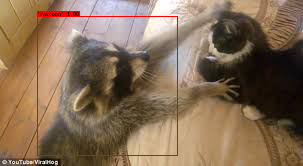

In [14]:
from PIL import Image
image = Image.open('./raccoon-84.jpg')
r_image = yolo_model.detect_image(image)
r_image

In [15]:

import cv2
import numpy as np
from PIL import Image
import timeit

starttime = timeit.default_timer()
cap = cv2.VideoCapture('Raccoon.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Raccoon-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
'raccoon' 0.50 (102, 0) (641, 558)
'raccoon' 0.58 (0, 0) (1280, 720)
0.049564520000103585
(416, 416, 3)
Found 2 boxes for img
'raccoon' 0.40 (85, 0) (654, 567)
'raccoon' 0.62 (0, 0) (1280, 720)
0.0531683179999618
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.73 (0, 0) (1280, 713)
0.047512453999843274
(416, 416, 3)
Found 2 boxes for img
'raccoon' 0.31 (81, 0) (656, 581)
'raccoon' 0.79 (0, 0) (1280, 713)
0.06325303700009499
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.93 (0, 0) (1280, 717)
0.047903279999900406
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.94 (0, 0) (1280, 720)
0.048022689999925205
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.93 (0, 0) (1280, 714)
0.04836562699983915
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.86 (0, 0) (1280, 707)
0.05299829199998385
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.91 (0, 0) (1280, 704)
0.04839567800013356
(416, 416, 3)
Found 1 boxes for img
'raccoon' 0.96 (0, 0) (1280, 708)

In [0]:
import cv2
import numpy as np
from PIL import Image
import timeit

starttime = timeit.default_timer()
cap = cv2.VideoCapture('Kangaroo.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Kangaroo-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 2 boxes for img
'kangaroo' 0.95 (33, 285) (453, 580)
'kangaroo' 1.00 (328, 310) (1007, 656)
0.1174330120011291
(416, 416, 3)
Found 2 boxes for img
'kangaroo' 0.91 (19, 275) (473, 565)
'kangaroo' 0.98 (336, 295) (1015, 695)
0.11275137099983112
(416, 416, 3)
Found 2 boxes for img
'kangaroo' 0.97 (9, 223) (490, 570)
'kangaroo' 0.99 (406, 289) (1028, 709)
0.11048607199882099
(416, 416, 3)
Found 4 boxes for img
'kangaroo' 0.55 (371, 312) (897, 559)
'kangaroo' 0.57 (628, 391) (1020, 675)
'kangaroo' 0.89 (387, 334) (1089, 702)
'kangaroo' 0.98 (0, 211) (471, 568)
0.120344146998832
(416, 416, 3)
Found 4 boxes for img
'kangaroo' 0.54 (369, 312) (899, 562)
'kangaroo' 0.54 (628, 391) (1019, 674)
'kangaroo' 0.89 (386, 332) (1088, 704)
'kangaroo' 0.98 (0, 211) (473, 568)
0.11891399799969804
(416, 416, 3)
Found 2 boxes for img
'kangaroo' 0.96 (431, 299) (1047, 695)
'kangaroo' 0.98 (18, 227) (445, 553)
0.11377843599984772
(416, 416